# Model 040 basicCh

This notebook tests the taylor diffuser component of landlab. At steady state, the taylor diffuser flux has the form of:
$qs = Ux = KS(1+(\frac{S}{Sc})^2 +...+ \frac{S}{Sc}^{2(n-1)})$
where E is the uplift rate, K is the diffusivity, S is the topographic slope, and Sc is a critical slope, and n is the number of terms. 

In [30]:
import numpy as np
from terrainbento import BasicCh
import matplotlib.pyplot as plt
from landlab import imshow_grid
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt

In [2]:
linear_diffusivity = 1.0
slope_crit = 0.3
nterms = 11
uplift_rate = 0.0005
node_spacing = 10.0
p = np.zeros(2*nterms-1)
#elevation = np.zeros(1000)

Let's say the nodes are numbered from 0 to 100, 50 being the top of the hillslope. That means the flux at node 90 needs to be able to transport all of the material from the crest to its own node (we use the second penultimate node to avoid boundary complications). Since node spacing is 10.0, this means that the flux at the last node should be: 

In [3]:
#x = (99-50)*10 + 5
x = 490
qs = uplift_rate*x

In [4]:
qs

0.245

Since $qs = KS(1+(\frac{S}{Sc})^2 +...+ \frac{S}{Sc}^{2(n-1)})$, we can bring qs to the right side of the equation and get $ 0 = -qs + KS(1+(\frac{S}{Sc})^2 +...+ \frac{S}{Sc}^{2(n-1)})$. We need to define the coefficients of the polynomial. First looking at the higher order terms:

In [5]:
for i in range(1,nterms+1):
      p[2*i-2] = linear_diffusivity*(1/(slope_crit**(2*(i-1))))

In [6]:
p

array([  1.00000000e+00,   0.00000000e+00,   1.11111111e+01,
         0.00000000e+00,   1.23456790e+02,   0.00000000e+00,
         1.37174211e+03,   0.00000000e+00,   1.52415790e+04,
         0.00000000e+00,   1.69350878e+05,   0.00000000e+00,
         1.88167642e+06,   0.00000000e+00,   2.09075158e+07,
         0.00000000e+00,   2.32305731e+08,   0.00000000e+00,
         2.58117479e+09,   0.00000000e+00,   2.86797199e+10])

In [7]:
p = np.fliplr([p])[0]

In [8]:
p

array([  2.86797199e+10,   0.00000000e+00,   2.58117479e+09,
         0.00000000e+00,   2.32305731e+08,   0.00000000e+00,
         2.09075158e+07,   0.00000000e+00,   1.88167642e+06,
         0.00000000e+00,   1.69350878e+05,   0.00000000e+00,
         1.52415790e+04,   0.00000000e+00,   1.37174211e+03,
         0.00000000e+00,   1.23456790e+02,   0.00000000e+00,
         1.11111111e+01,   0.00000000e+00,   1.00000000e+00])

In [9]:
p = np.append(p,qs)

In [10]:
p_roots = np.roots(p)
p_roots

array([ 0.29042769+0.07944358j,  0.29042769-0.07944358j,
        0.26047058+0.1558189j ,  0.26047058-0.1558189j ,
        0.20947546+0.22299748j,  0.20947546-0.22299748j,
        0.14015812+0.27399796j,  0.14015812-0.27399796j,
        0.05802837+0.30327819j,  0.05802837-0.30327819j,
       -0.02978485+0.30752865j, -0.02978485-0.30752865j,
       -0.11546559+0.2858754j , -0.11546559-0.2858754j ,
       -0.19130294+0.23984087j, -0.19130294-0.23984087j,
       -0.25042138+0.17308573j, -0.25042138-0.17308573j,
       -0.28754148+0.09092074j, -0.28754148-0.09092074j, -0.16808799+0.j        ])

In [11]:
steady_S = np.real(p_roots[-1])
print(steady_S)

-0.168087988927


In [12]:
steady_S = abs(steady_S)
print(steady_S)

0.168087988927


Now run the erosion model and test against this steady state prediction. 

In [13]:
#parameter dictionary
params = {'number_of_node_rows' : 10,
         'number_of_node_columns' : 100,
         'node_spacing' : 10.0,
         'east_boundary_closed' : False,
         'north_boundary_closed' : True,
         'west_boundary_closed' : False,
         'south_boundary_closed' :True,
         'dt' : 10,
         'K_sp' : 0,
         'm_sp' : 0.5,
         'n_sp' : 1.0,
         'linear_diffusivity' : linear_diffusivity,
         'slope_crit' : slope_crit,
         'outlet_lowering_rate' : uplift_rate,
         'output_filename': 'model_040_output',}

In [14]:
basic = BasicCh(params=params)
tolerance = 0.0001
dt = 1

In [15]:
elapsed_time = 0
keep_running = True
while keep_running == True:
   
    basic.run_one_step(dt)
    
    slope1 = np.copy(basic.grid.at_node['topographic__steepest_slope'][101])
    slope2 = np.copy(basic.grid.at_node['topographic__steepest_slope'][198])
    
    if elapsed_time % 10000 == 0:
        print(elapsed_time)
        
    elapsed_time += dt
    
    if abs((slope1-steady_S)) <= tolerance and abs((slope2-steady_S)) <= tolerance:
        keep_running = False

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000


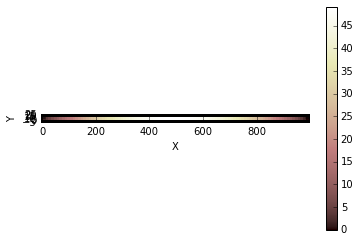

In [16]:
%matplotlib inline
imshow_grid(basic.grid, 'topographic__elevation')

In [24]:
basic.grid.at_node['topographic__steepest_slope'][101]

0.16798799064147688

In [25]:
steady_S

0.16808798892669097

In [26]:
0.16808798892669097 - 0.16798799064147688

9.999828521409238e-05

In [34]:
topo_profile = basic.grid.at_node['topographic__elevation'][basic.grid.node_y == 10] + uplift_rate*elapsed_time
topo = basic.grid.at_node['topographic__elevation']
domain = np.arange(0, max(basic.grid.node_x + 10.0), 10.0)
#plt.plot(domain,topo)
#len(topo_profile)

In [35]:
basic.grid.at_node['topographic__steepest_slope']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

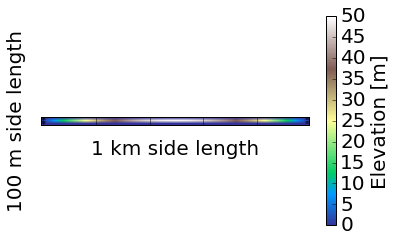

In [43]:
#plotting param
matplotlib.rcParams.update({'font.size': 20})

# #instantiate figure and plot
topo_fig = plt.figure(figsize=(6, 3.75))
t1 = plt.subplot()
topo = topo.reshape(3,100)
ts1_plot = t1.imshow(topo[::-1], cmap='terrain', vmin = 0, vmax = 50)

#add colorbar
cb = plt.colorbar(ts1_plot, label = 'Elevation [m]')

#axis labels
t1.tick_params(labelbottom='off', labelleft='off') 
t1.set_ylabel('100 m side length', labelpad = 15)
t1.set_xlabel('1 km side length', labelpad = 15)

#save figure
topo_fig.savefig('cubic_diffusion_topo.eps',bbox_inches='tight', dpi=300)


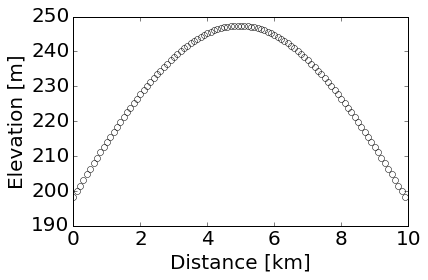

In [54]:
##instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
hillslope = plt.subplot()

#plotting param
matplotlib.rcParams.update({'font.size': 20})

#parameters
uplift_rate = 0.0005
hillslope_diffusivity = 1.0

#plot the actual profile
hillslope.plot(domain * node_spacing / 1000, topo_profile, marker='o', c='k', linewidth = 0, markerfacecolor='None', label = 'Numerical Solution')

#plot the theoretical profile
#x = np.arange(-max(domain) / 2., max(domain) / 2. + dx, dx)
#theory_profile = (uplift_rate / hillslope_diffusivity) * \
#    ((max(x+max(x))/2.)**2 / 2.0) + ((-uplift_rate / hillslope_diffusivity) *\
#    (x**2 / 2.0))
#plt.plot((x + max(x)) * dx / 1000, theory_profile , linestyle='-', c='grey', linewidth = 2, label = 'Analytical Solution')

#axis labels
hillslope.set_xlabel('Distance [km]')
hillslope.set_ylabel('Elevation [m]')

#legend
#hillslope.legend(scatterpoints = 1, prop={'size':12})

#save figure
fig.savefig('cubic_diff_topo.eps',bbox_inches='tight', dpi=300)

In [39]:
topo.reshape(10,100)

ValueError: total size of new array must be unchanged